# Setup

Install previous version of pytorch due to compatibility issues with fastai

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 19kB/s 
     |████████████████████████████████| 4.0MB 37.8MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


Import required packages

In [0]:
import sklearn
from sklearn.metrics import confusion_matrix as confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import csv
import os
import fastai
from fastai import *
from fastai.text import * 
from functools import partial
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.metrics import error_rate

# Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
from google.colab import drive

Authenticate to Google Drive to access dataset folder:

In [3]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


General parameters and settings

In [0]:
models_folder = "/content/drive/My Drive/document-classification/models/final-models/"
dataset_path = "/content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192"
model_name = "late-fusion_1488-288-192_valid-acc-74.30"

path_train_ocr = os.path.join(dataset_path, 'train_extracted.csv')
path_test_ocr = os.path.join(dataset_path, 'test_extracted.csv')

# Shape of the images in input to the CNN
cnn_image_shape = (224, 224)
# Number of images classes
n_classes = 16
# Batch size to be used in training
batch_size = 32

# Dataset loading

Load visual dataset:

In [5]:
df_train = pd.read_csv(os.path.join(dataset_path, "train-labels.csv"), names=["image", "label"])
df_test = pd.read_csv(os.path.join(dataset_path, "test-labels.csv"), names=["image", "label"])
df_train["is_valid"] = False
df_test["is_valid"] = True
df_joined = pd.concat([df_train, df_test], ignore_index=True)
print(df_joined.head())
print(df_joined.tail())

data_vgg = (ImageList.from_df(df_joined, dataset_path, cols="image")#, folder=mini_dataset_path)
        .split_from_df()
        .label_from_df()
        .transform(size=cnn_image_shape, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize())

                                 image  label  is_valid
0  train/0/0/0/0/94002065_94002066.tif     10     False
1         train/0/0/0/1/2074950097.tif     10     False
2      train/0/0/0/2/50284095-4103.tif      6     False
3           train/0/0/0/3/04003306.tif     10     False
4         train/0/0/0/4/2024967978.tif     11     False
                              image  label  is_valid
1675    test/0/1/8/7/0060212680.tif      0      True
1676    test/0/1/8/8/2023447951.tif      6      True
1677  test/0/1/8/9/corti0013630.tif      9      True
1678    test/0/1/9/0/2079066784.tif      2      True
1679    test/0/1/9/1/2047951324.tif      9      True


Load textual dataset:

In [6]:
df_trn, df_test = pd.read_csv(path_train_ocr,names=['text','label']), pd.read_csv(path_test_ocr,names=['text','label'])
print(df_trn.shape, df_test.shape)

# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_test, path = "",
                                  text_cols="text", label_cols="label")
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_test,
                                      text_cols="text", label_cols="label", vocab=data_lm.train_ds.vocab, bs=batch_size)

(1488, 2) (192, 2)


Concatenate the two dataset:

In [0]:
# Per accedere ad alcune funzionalità di fastai è necessario definire cose aggiuntive
# nel Dataset
class ConcatDataset(Dataset):
    def __init__(self, x_images: ImageList, x_texts: TextList, y): 
        self.x_images = x_images
        self.x_texts = x_texts
        self.y = y
        self.c = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return (self.x_images[i].apply_tfms([], size=cnn_image_shape, resize_method=ResizeMethod.SQUISH),
                                      self.x_texts[i]), self.y[i]

train_ds = ConcatDataset(data_vgg.train_ds.x, data_clas.train_ds.x, data_vgg.train_ds.y)
test_ds = ConcatDataset(data_vgg.valid_ds.x, data_clas.valid_ds.x, data_vgg.valid_ds.y)

Define a collate function to pass to the DataBunch. This function will replace the one used by the Dataloader and describe how to collate the samples taken for a batch from the ConcatDataset.

In [0]:
def my_collate(batch):
    x,y = list(zip(*batch))
    x1,x2 = list(zip(*x))
    x1 = to_data(x1)
    x1 = torch.stack(x1)
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    
    return (x1, x2), y

Create the DataBunch from the custom datasets and the collate function.

In [0]:
data = DataBunch.create(train_ds, test_ds, collate_fn=my_collate, path=dataset_path, bs=batch_size)

Create the original concat model from the two separate model

In [10]:
input_models_folder = "/content/drive/My Drive/document-classification/models/final-models/"

image_class_model = "image-class_1488-288-192_valid-acc-67.36"
text_class_model = "text-class_1488-288-192_valid-acc-59.38"


learn_vgg = cnn_learner(data_vgg, models.vgg16_bn, metrics=accuracy,
                    model_dir=input_models_folder)
learn_vgg.load(image_class_model);
#learn_vgg.model[-1] = learn_vgg.model[-1][:-3] 


learn_text = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.7,
                                     model_dir=input_models_folder)
learn_text.load(text_class_model)
#learn_text.model[-1].layers = learn_text.model[-1].layers[:-3] 



Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


RNNLearner(data=TextClasDataBunch;

Train: LabelList (1488 items)
x: TextList
xxbos the tobacco institute ca xxunk wame 08 xxunk name xxunk oars enter wa tate l xxunk ere xxunk i street . xxunk washington . bc xxunk pay date xxunk . fa xxunk gad li xxwrep 5 ee xxunk xxunk to the ap xxunk xxunk times order of pl rok xxunk pron tk al xxunk non xxunk xo xxunk xxunk po 200 25 hosk xxrep 4 o ion xxunk xxunk 26 xxunk xxunk,xxbos xxunk eo hea xxunk xxunk xxunk xxunk xxunk xxunk form xxunk 7 xxunk soe xxunk 6 20 no,xxbos the anatomical record 210 115 123 1984 chronic infusion opiate peptides rat cerebrospinal fluid with osmotic minipumps lc . saland e. xxunk anv a. xxunk department anatomy the university new mexico school medicine albuquerque nm xxunk abstract beta endorphin related opiate peptides opiate xxunk xxunk naloxone chronically infused periods 24 48 hours lateral cerebral ventricle adult male rats using alza osmotic minipumps . previous studies suggested chemotactic like effect opiat

# Model loading

In [0]:
class ConcatModel(nn.Module):
    def __init__(self, mod_cnn, mod_nlp, input_dim, output_dim): 
        super().__init__()
        self.mod_cnn = mod_cnn
        self.mod_nlp = mod_nlp
        
       # Final custom part
        n_neurons = 256
        last_layers = []
        last_layers += bn_drop_lin(input_dim, n_neurons, p=0, actn=nn.ReLU(inplace=True))
        last_layers += bn_drop_lin(n_neurons, output_dim, p=0.5)

        self.layers = nn.Sequential(*last_layers)

    def forward(self, x_cnn, x_nlp):
        x_cnn = self.mod_cnn(x_cnn)
        x_nlp = self.mod_nlp(x_nlp)[0]
        x = torch.cat([x_cnn, x_nlp], dim=1)
        return self.layers(x)    

input_dim = 32
output_dim = 16
model = ConcatModel(learn_vgg.model, learn_text.model, input_dim, output_dim)

In [0]:
model

In [20]:
loss_func = nn.CrossEntropyLoss()
layer_groups = [nn.Sequential(*flatten_model(learn_text.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_text.layer_groups[1])),
                nn.Sequential(*(flatten_model(learn_text.layer_groups[2]) + 
                                flatten_model(learn_vgg.layer_groups[0]))),
                nn.Sequential(*(flatten_model(learn_text.layer_groups[3]) + 
                                flatten_model(learn_vgg.layer_groups[1]))),
                nn.Sequential(*(flatten_model(learn_text.layer_groups[4]) + 
                                flatten_model(learn_vgg.layer_groups[2]))),
                nn.Sequential(*flatten_model(model.layers))]

learn = Learner(data, model, loss_func=loss_func, metrics=accuracy, layer_groups=layer_groups,
                path='/content/drive/My Drive/document-classification/models/final-models/')

learn.load(model_name)

Learner(data=DataBunch;

Train: <__main__.ConcatDataset object at 0x7f5c0102bd68>;

Valid: <__main__.ConcatDataset object at 0x7f5c0102bcf8>;

Test: None, model=ConcatModel(
  (mod_cnn): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), strid

# Performance calculation

Accuracy:

In [15]:
learn.validate()

[1.1552892, tensor(0.7552)]

Confusion matrix:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


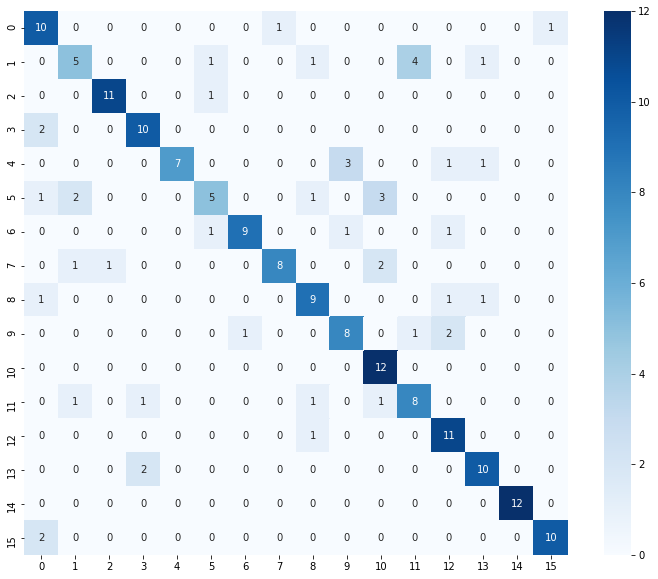

In [23]:
val_preds,val_targets = learn.get_preds()
val_preds = torch.argmax(val_preds, dim=1)

conf_matrix = confusion_matrix(y_true=val_targets, y_pred=val_preds)
plt.figure(figsize = (13,10))
sn.heatmap(conf_matrix, annot=True, square=True, cmap="Blues")